In [1]:
# Import required libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Add project root to path for imports
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules from new structure
from configs.config import Config
from src.utils.data_utils import (
    load_labels_from_csv, 
    SignLanguageDataset, 
    create_data_loaders,
    flip_keypoints,
    transform_keypoints
)
from src.models.model_utils import (
    create_adjacency_matrix,
    create_model
)
from src.models.model import (
    HGC_LSTM,
    AttentionPooling
)
from src.training.train_utils import (
    train_model
)
from src.utils.visualization_utils import (
    visualize_training_process,
    analyze_model_performance
)

print("✅ All modules imported successfully!")
print(f"📦 Project structure reorganized with modular imports")
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🔧 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Device: {torch.cuda.get_device_name(0)}")
print()

# Initialize configuration
config = Config()
print("🔧 Configuration loaded from configs/config.py")
print(f"📊 Data from: {config.data.input_kp_path}")
print(f"💾 Models save to: {config.model.checkpoint_dir}")
print(f"📈 Plots save to: {config.output.plots_dir}")

✅ All modules imported successfully!
📦 Project structure reorganized with modular imports
🐍 Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
🔥 PyTorch: 2.7.0+cu126
🔧 CUDA Available: True
🔧 CUDA Device: NVIDIA GeForce RTX 3070 Ti

🔧 Configuration loaded from configs/config.py
📊 Data from: dataset/Keypoints
💾 Models save to: outputs/models
📈 Plots save to: outputs/plots


In [2]:
# Import data utilities
from src.utils.data_utils import load_labels_from_csv

# Load labels
video_to_label_mapping, label_to_idx, unique_labels, id_to_label_mapping = load_labels_from_csv(None, config)
num_classes = len(unique_labels)

In [3]:
# Import data augmentation and dataset utilities
from src.utils.data_utils import flip_keypoints, transform_keypoints, SignLanguageDataset

In [4]:
# Create datasets with stratified split and augmentation
print("[INFO] Creating datasets...")
keypoints_dir = config.data.keypoints_output_dir

# Set random seed for reproducible splits
np.random.seed(42)

# Get parameters from config
use_strategy = config.data.use_strategy


# Training uses augmentation, validation does not (for fair evaluation)
train_augmentations = getattr(config.data, 'augmentations', [])
val_augmentations = [] 

print(f"Configuration:")
print(f"   Split strategy: {'Stratified' if use_strategy else 'Random'}")
print(f"   Train augmentations: {train_augmentations if train_augmentations else 'None'}")
print(f"   Val augmentations: {val_augmentations if val_augmentations else 'None (for fair evaluation)'}")
if 'translation' in train_augmentations:
    print(f"   Translation range: ±{config.data.translation_range}")
if 'scaling' in train_augmentations:
    print(f"   Scale range: ±{config.data.scale_range}")

train_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, config,
    split_type='train', 
    augmentations=train_augmentations,
    use_strategy=use_strategy
)

val_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, config,
    split_type='val', 
    augmentations=val_augmentations,
    use_strategy=use_strategy
)

print(f"\n[INFO] Dataset summary:")
print(f"  Total classes: {len(unique_labels)}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Strategy: {'Stratified' if use_strategy else 'Random'} split")

[INFO] Creating datasets...
Configuration:
   Split strategy: Stratified
   Train augmentations: ['flip', 'translation', 'scaling']
   Val augmentations: None (for fair evaluation)
   Translation range: ±0.1
   Scale range: ±0.1
 Using stratified split strategy
 TRAIN dataset: 240 original files
 Augmentation enabled: 1920 total samples (x8)
  - Augmentations: ['flip', 'translation', 'scaling']
  - Total combinations: 8
  - Combinations: ['original', 'flip', 'translation', 'scaling', 'flip+translation', 'flip+scaling', 'translation+scaling', 'flip+translation+scaling']
 TRAIN class distribution:
  Class 1: 16 samples
  Class 2: 16 samples
  Class 3: 16 samples
  Class 4: 16 samples
  Class 5: 16 samples
  Class 6: 16 samples
  Class 7: 16 samples
  Class 8: 16 samples
  Class 9: 16 samples
  Class 10: 16 samples
  Class 11: 16 samples
  Class 12: 16 samples
  Class 13: 16 samples
  Class 14: 16 samples
  Class 15: 16 samples
 ✓ Balanced: 16 samples per class
 Using stratified split str

In [5]:
# Import data loader utility
from src.utils.data_utils import create_data_loaders

# Create data loaders
print("\n[INFO] Creating data loaders...")
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, config)


[INFO] Creating data loaders...
 Train batches: 240
 Valid batches: 8
 Batch size: 8
 Data Augmentation (flip + translation + scaling): 240 original → 1920 total samples
 Augmentation combinations: ['original', 'flip', 'translation', 'scaling', 'flip+translation', 'flip+scaling', 'translation+scaling', 'flip+translation+scaling']
 Sample keypoints shape: torch.Size([8, 75, 75, 2])
 Sample labels shape: torch.Size([8])


In [6]:
# Import model utilities
from src.models.model_utils import create_adjacency_matrix

A = create_adjacency_matrix(config)
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.hgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [7]:
# Import model classes and utilities
from src.models.model_utils import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(config, A, num_classes, device)

Model created with 285584 parameters
Model configuration:
  - GCN layers: 2
  - GCN hidden dim: 128
  - LSTM hidden dim: 128
  - LSTM layers: 1
  - Bidirectional: True
  - Dropout: 0.5
  - Pooling type: attention
  - Sequence length: 75
  - Number of vertices: 75
  - Using Attention Pooling with dropout: 0.5
  - Attention weights can be visualized after forward pass


In [8]:
# Import training utilities
from src.training.train_utils import train_model

In [9]:
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")
history = train_model(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 300
  - Batch size: 8
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 50
Epoch 001/300 | Train Loss: 2.7263 Acc: 06.82% | Val Loss: 2.7315 Acc: 06.67% | LR: 0.00100000
Epoch 001/300 | Train Loss: 2.7263 Acc: 06.82% | Val Loss: 2.7315 Acc: 06.67% | LR: 0.00100000
Epoch 002/300 | Train Loss: 2.7126 Acc: 07.55% | Val Loss: 2.7225 Acc: 05.00% | LR: 0.00100000
Epoch 002/300 | Train Loss: 2.7126 Acc: 07.55% | Val Loss: 2.7225 Acc: 05.00% | LR: 0.00100000
Epoch 003/300 | Train Loss: 2.7061 Acc: 07.19% | Val Loss: 2.7275 Acc: 06.67% | LR: 0.00100000
Epoch 003/300 | Train Loss: 2.7061 Acc: 07.19% | Val Loss: 2.7275 Acc: 06.67% | LR: 0.00100000
Epoch 004/300 | Train Loss: 2.7010 Acc: 08.85% | Val Loss: 2.7181 Acc: 08.33% | LR: 0.00100000
Epoch 004/300 | Train Loss: 2.7010 Acc: 08.85% | Val Loss: 2.7181 Acc: 08.33% | LR: 0.00100000
Epoch 005/300 | Train Loss: 2.6590 Acc: 10.78% | V

# Training Process Visualization

This section provides essential visualization of the training process including:
- **Loss curves**: Training and validation loss over epochs
- **Accuracy curves**: Training and validation accuracy over epochs  
- **Confusion matrix**: Model performance analysis on validation set

[INFO] Generating training process visualization...
Training curves saved to: training_plots/training_curves.png
Training curves saved to: training_plots/training_curves.png


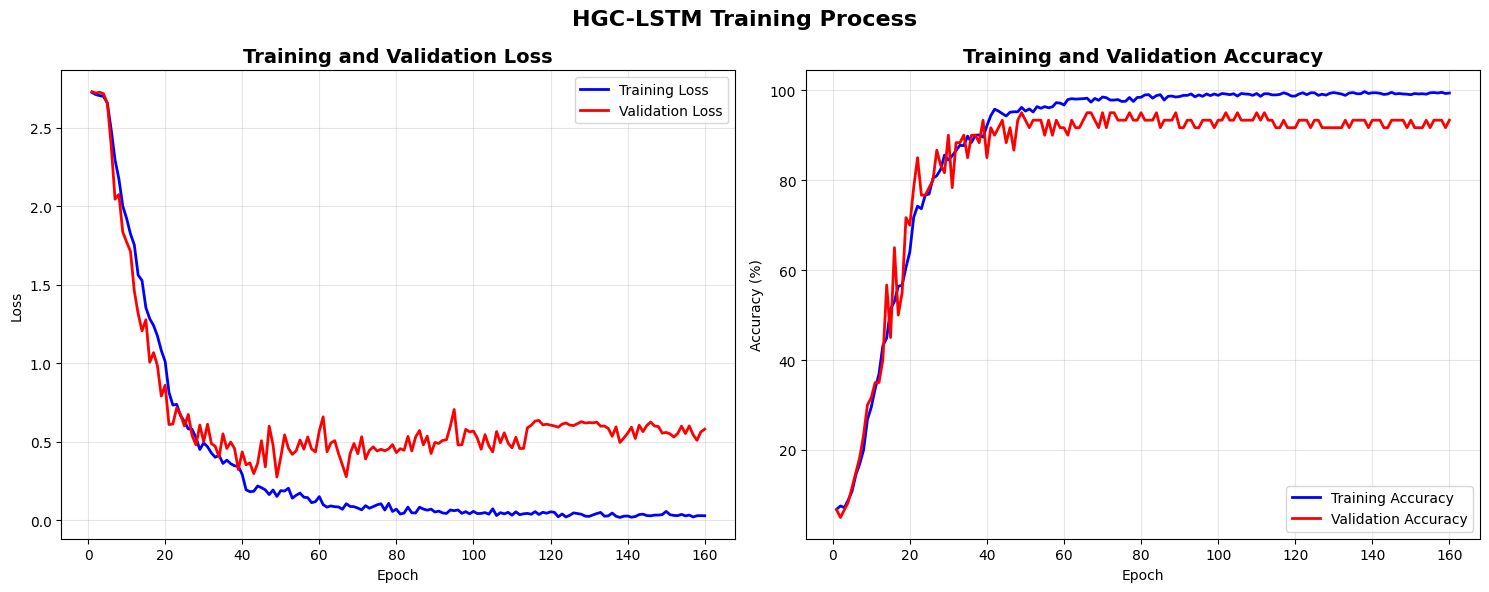


📊 TRAINING SUMMARY:
   Best Validation Accuracy: 95.00% (Epoch 49)
   Final Training Accuracy: 99.38%


In [10]:
# Import visualization utilities
from src.utils.visualization_utils import visualize_training_process

# Visualize training process
print("[INFO] Generating training process visualization...")
training_fig = visualize_training_process(history, config, save_plots=True)

[INFO] Analyzing model performance...
 Analyzing model performance on validation set...
Confusion matrix saved to: training_plots/confusion_matrix.png
Confusion matrix saved to: training_plots/confusion_matrix.png


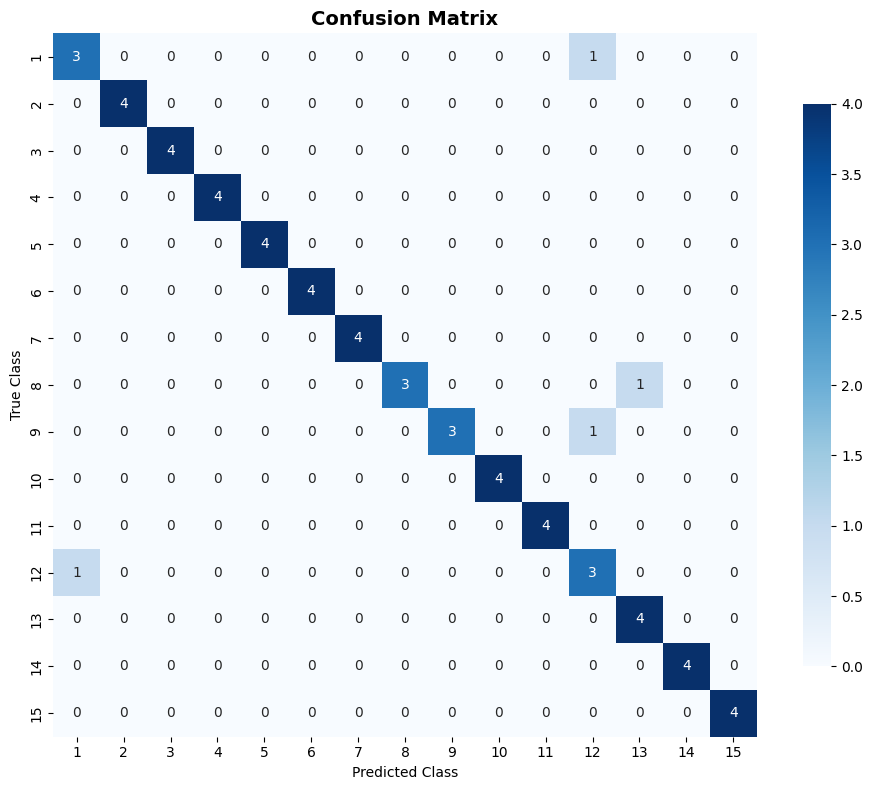


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class_1       0.75      0.75      0.75         4
     Class_2       1.00      1.00      1.00         4
     Class_3       1.00      1.00      1.00         4
     Class_4       1.00      1.00      1.00         4
     Class_5       1.00      1.00      1.00         4
     Class_6       1.00      1.00      1.00         4
     Class_7       1.00      1.00      1.00         4
     Class_8       1.00      0.75      0.86         4
     Class_9       1.00      0.75      0.86         4
    Class_10       1.00      1.00      1.00         4
    Class_11       1.00      1.00      1.00         4
    Class_12       0.60      0.75      0.67         4
    Class_13       0.80      1.00      0.89         4
    Class_14       1.00      1.00      1.00         4
    Class_15       1.00      1.00      1.00         4

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
wei

In [11]:
# Import model performance analysis
from src.utils.visualization_utils import analyze_model_performance

# Analyze model performance
print("[INFO] Analyzing model performance...")
performance_results = analyze_model_performance(model, val_loader, device, config, unique_labels, id_to_label_mapping)

# Attention Weights Visualization

This section visualizes the attention weights from the HGC-LSTM model to understand which keypoints the model focuses on during prediction.

In [12]:
# Visualize attention weights
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention_weights(model, data_loader, device, config, num_samples=5):
    """
    Visualize attention weights for a few samples
    """
    model.eval()
    attention_weights_list = []
    predictions_list = []
    labels_list = []
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            if i >= num_samples:
                break
                
            data = data.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(data)
            
            # Get attention weights if available
            if hasattr(model, 'attention_pooling') and hasattr(model.attention_pooling, 'attention_weights'):
                attention_weights = model.attention_pooling.attention_weights
                attention_weights_list.append(attention_weights.cpu().numpy())
                predictions_list.append(torch.argmax(outputs, dim=1).cpu().numpy())
                labels_list.append(labels.cpu().numpy())
    
    # Plot attention weights
    if attention_weights_list:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, (attn_weights, pred, true_label) in enumerate(zip(attention_weights_list[:6], predictions_list[:6], labels_list[:6])):
            if i < len(axes):
                # Average attention weights across batch dimension
                avg_attn = attn_weights.mean(axis=0)  # Shape: (sequence_length,)
                
                axes[i].plot(avg_attn, marker='o', linewidth=2, markersize=4)
                axes[i].set_title(f'Sample {i+1}\nPred: {pred[0]}, True: {true_label[0]}', fontsize=12)
                axes[i].set_xlabel('Time Steps', fontsize=10)
                axes[i].set_ylabel('Attention Weight', fontsize=10)
                axes[i].grid(True, alpha=0.3)
                axes[i].set_ylim(0, max(avg_attn) * 1.1)
        
        # Remove empty subplots
        for j in range(len(attention_weights_list), len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.suptitle('Attention Weights Visualization', fontsize=16, y=1.02)
        
        # Save plot
        plt.savefig(f"{config.output.plots_dir}/attention_weights.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig
    else:
        print("No attention weights found. Model might not have attention mechanism.")
        return None

# Visualize attention weights
print("[INFO] Visualizing attention weights...")
attention_fig = visualize_attention_weights(model, val_loader, device, config, num_samples=6)

[INFO] Visualizing attention weights...
No attention weights found. Model might not have attention mechanism.


[INFO] Visualizing keypoint importance heatmap...


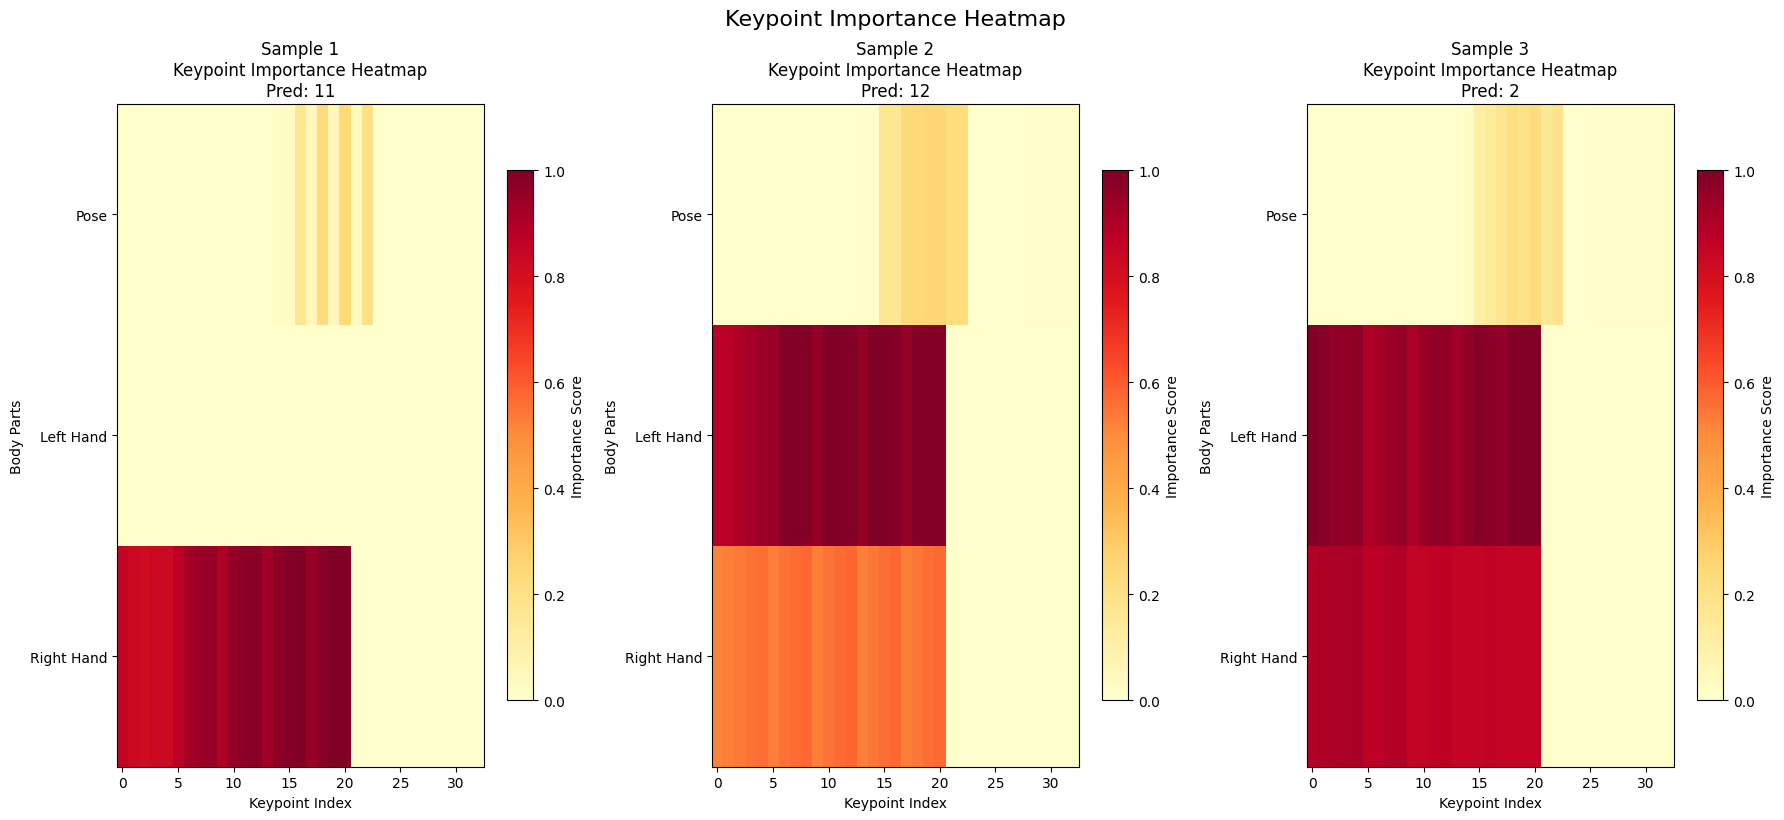

In [13]:
# Visualize attention weights as heatmap across keypoints
def visualize_keypoint_attention_heatmap(model, data_loader, device, config, num_samples=3):
    """
    Visualize attention weights as heatmap showing which keypoints are most important
    """
    model.eval()
    
    # Define keypoint groups for better visualization
    keypoint_groups = {
        'Pose': list(range(0, 33)),          # Pose landmarks (0-32)
        'Left Hand': list(range(33, 54)),     # Left hand landmarks (33-53)
        'Right Hand': list(range(54, 75))     # Right hand landmarks (54-74)
    }
    
    with torch.no_grad():
        sample_count = 0
        fig, axes = plt.subplots(1, num_samples, figsize=(6*num_samples, 8))
        if num_samples == 1:
            axes = [axes]
        
        for batch_idx, (data, labels) in enumerate(data_loader):
            if sample_count >= num_samples:
                break
                
            data = data.to(device)  # Shape: (batch_size, seq_len, num_vertices, in_channels)
            batch_size = data.shape[0]
            
            # Forward pass
            outputs = model(data)
            
            # Extract features from different layers to simulate attention
            # This is a approximation since we need to modify the model to get actual attention weights
            
            for sample_idx in range(min(batch_size, num_samples - sample_count)):
                # Calculate feature importance by variance across time steps
                sample_data = data[sample_idx]  # Shape: (seq_len, num_vertices, in_channels)
                
                # Calculate variance for each keypoint across time steps
                keypoint_variance = torch.var(sample_data, dim=0).mean(dim=1)  # Shape: (num_vertices,)
                keypoint_importance = keypoint_variance / keypoint_variance.max()
                
                # Create heatmap data
                heatmap_data = []
                group_names = []
                
                for group_name, indices in keypoint_groups.items():
                    group_importance = keypoint_importance[indices].cpu().numpy()
                    heatmap_data.extend(group_importance)
                    group_names.extend([f'{group_name}_{i}' for i in range(len(indices))])
                
                # Reshape for heatmap (create a 2D representation)
                heatmap_matrix = []
                start_idx = 0
                max_len = max(len(indices) for indices in keypoint_groups.values())
                
                for group_name, indices in keypoint_groups.items():
                    group_data = keypoint_importance[indices].cpu().numpy()
                    # Pad with zeros to make all groups same length
                    padded_data = np.pad(group_data, (0, max_len - len(group_data)), 'constant')
                    heatmap_matrix.append(padded_data)
                
                heatmap_matrix = np.array(heatmap_matrix)
                
                # Plot heatmap
                ax = axes[sample_count]
                im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
                
                # Customize plot
                ax.set_title(f'Sample {sample_count + 1}\nKeypoint Importance Heatmap\nPred: {torch.argmax(outputs[sample_idx]).item()}', 
                           fontsize=12)
                ax.set_ylabel('Body Parts', fontsize=10)
                ax.set_xlabel('Keypoint Index', fontsize=10)
                ax.set_yticks(range(len(keypoint_groups)))
                ax.set_yticklabels(list(keypoint_groups.keys()))
                
                # Add colorbar
                cbar = plt.colorbar(im, ax=ax, shrink=0.8)
                cbar.set_label('Importance Score', fontsize=10)
                
                sample_count += 1
                if sample_count >= num_samples:
                    break
        
        plt.tight_layout()
        plt.suptitle('Keypoint Importance Heatmap', fontsize=16, y=1.02)
        
        # Save plot
        plt.savefig(f"{config.output.plots_dir}/keypoint_attention_heatmap.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig

# Visualize keypoint attention heatmap
print("[INFO] Visualizing keypoint importance heatmap...")
heatmap_fig = visualize_keypoint_attention_heatmap(model, val_loader, device, config, num_samples=3)

[INFO] Visualizing temporal attention patterns...


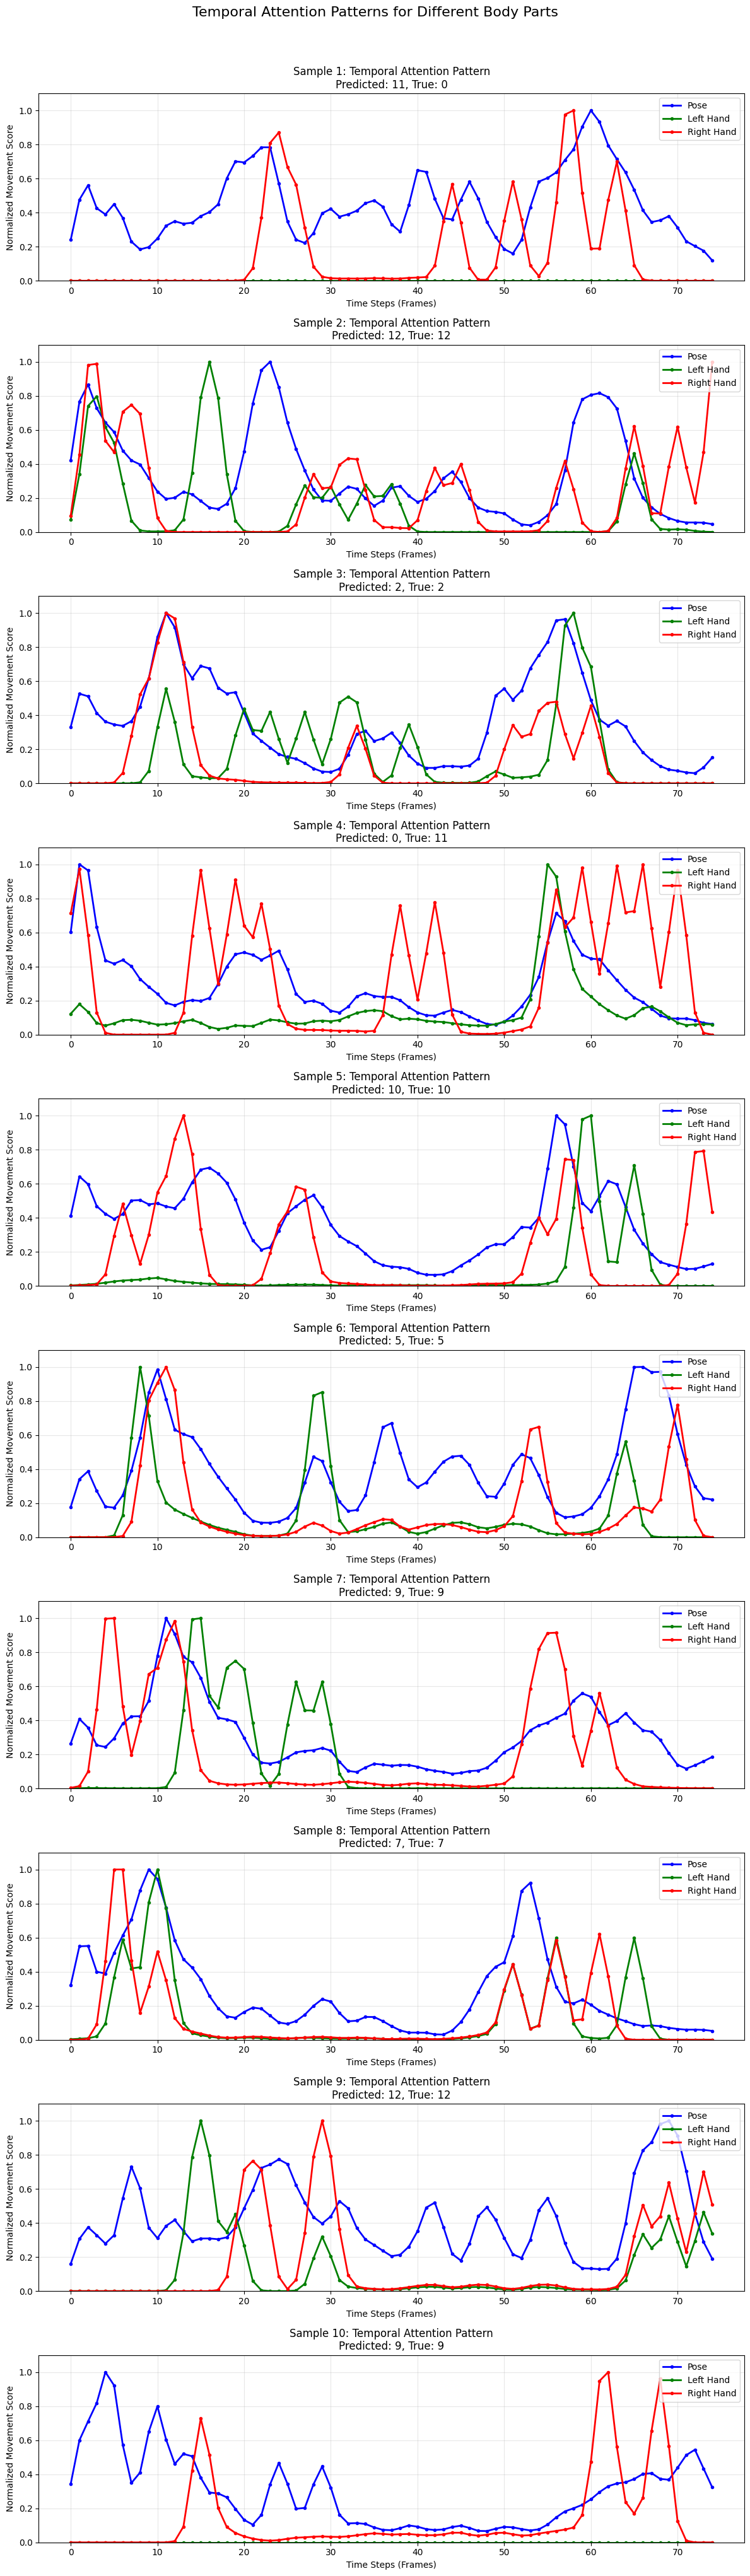

In [14]:
# Visualize temporal attention patterns
def visualize_temporal_attention(model, data_loader, device, config, num_samples=2):
    """
    Visualize how attention changes over time for different body parts
    """
    model.eval()
    
    keypoint_groups = {
        'Pose': list(range(0, 33)),
        'Left Hand': list(range(33, 54)),
        'Right Hand': list(range(54, 75))
    }
    
    colors = ['blue', 'green', 'red', 'orange']
    
    with torch.no_grad():
        sample_count = 0
        fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
        if num_samples == 1:
            axes = [axes]
        
        for batch_idx, (data, labels) in enumerate(data_loader):
            if sample_count >= num_samples:
                break
                
            data = data.to(device)
            batch_size = data.shape[0]
            seq_len = data.shape[1]
            
            outputs = model(data)
            
            for sample_idx in range(min(batch_size, num_samples - sample_count)):
                sample_data = data[sample_idx]  # Shape: (seq_len, num_vertices, in_channels)
                
                ax = axes[sample_count]
                
                # Calculate temporal importance for each body part
                for i, (group_name, indices) in enumerate(keypoint_groups.items()):
                    # Calculate movement/variance for this group over time
                    group_data = sample_data[:, indices, :]  # Shape: (seq_len, group_size, in_channels)
                    
                    # Calculate temporal variance for this group
                    temporal_variance = []
                    for t in range(seq_len):
                        if t > 0:
                            # Calculate change from previous frame
                            change = torch.mean(torch.abs(group_data[t] - group_data[t-1]))
                            temporal_variance.append(change.item())
                        else:
                            temporal_variance.append(0.0)
                    
                    # Smooth the signal
                    if len(temporal_variance) > 5:
                        from scipy import ndimage
                        temporal_variance = ndimage.gaussian_filter1d(temporal_variance, sigma=1.0)
                    
                    # Normalize
                    if max(temporal_variance) > 0:
                        temporal_variance = [x / max(temporal_variance) for x in temporal_variance]
                    
                    # Plot
                    ax.plot(range(seq_len), temporal_variance, 
                           label=group_name, color=colors[i], linewidth=2, marker='o', markersize=3)
                
                ax.set_title(f'Sample {sample_count + 1}: Temporal Attention Pattern\n'
                           f'Predicted: {torch.argmax(outputs[sample_idx]).item()}, '
                           f'True: {labels[sample_idx].item()}', fontsize=12)
                ax.set_xlabel('Time Steps (Frames)', fontsize=10)
                ax.set_ylabel('Normalized Movement Score', fontsize=10)
                ax.legend(loc='upper right')
                ax.grid(True, alpha=0.3)
                ax.set_ylim(0, 1.1)
                
                sample_count += 1
                if sample_count >= num_samples:
                    break
        
        plt.tight_layout()
        plt.suptitle('Temporal Attention Patterns for Different Body Parts', fontsize=16, y=1.02)
        
        # Save plot
        plt.savefig(f"{config.output.plots_dir}/temporal_attention_patterns.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig

# Check if scipy is available, if not use a simple smoothing
try:
    from scipy import ndimage
except ImportError:
    print("Scipy not available, using simple smoothing...")

print("[INFO] Visualizing temporal attention patterns...")
temporal_fig = visualize_temporal_attention(model, val_loader, device, config, num_samples=10)